# Psychoinformatics
by 蔡宥杏 (b06902054@ntu.edu.tw)

## 1 Analyze what videos go viral?

Please use <a href="https://developers.google.com/youtube/v3/code_samples/python">YouTube APIs</a> to carry out a data-driven or hypothesis-driven microstudy about the characteristics of viral videos.

You need to present, here in this notebook, AT LEAST two <b>statistical</b> figures or tables as supporting evidence for your arguments. Each of these figures/tables deserves 3 points.

### 前提

    本來想利用搜尋的方式，打關鍵字"Taiwan"之類的來看看會出現哪些影片，但意外地發現這個關鍵字好像被鎖定了(?)嘗試著依其他國家為關鍵搜尋，有的可行，像是"japan" "UK"，但"Korea"好像也不行，但不排除是我自己程式的問題。改變一下策略，為了因應題目要求要分析熱門影片，我想到我國小時很常在youtube上看的影片，一顆一直嘲笑別人的橘子，在當時應該是熱門影片。就以這個單一小主題下去做個小分析。

### Step1 - Access data
    參考範本:
    https://medium.com/greyatom/youtube-data-in-python-6147160c5833
    https://stackoverflow.com/questions/16742381/how-to-convert-youtube-api-duration-to-seconds/16743442
    

In [1]:
from apiclient.discovery import build
from apiclient.errors import HttpError
from oauth2client.tools import argparser
import pandas as pd
import pprint 
import matplotlib.pyplot as pd

DEVELOPER_KEY = "TAP YOUR KEY"
YOUTUBE_API_SERVICE_NAME = "youtube"
YOUTUBE_API_VERSION = "v3"

def youtube_search(q, max_results=50,order="relevance", token=None, location=None, location_radius=None):

    youtube = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION,developerKey=DEVELOPER_KEY)

    search_response = youtube.search().list(
    q=q,
    type="video",
    pageToken=token,
    order = order,
    part="id,snippet", # Part signifies the different types of data you want
    maxResults=max_results,
    location=location,
    locationRadius=location_radius).execute()

    title = []
    channelTitle = []
    viewCount = []
    likeCount = []
    dislikeCount = []
    commentCount = []
    tags = []
    videos = []
    duration = []
    url = []
    
    for search_result in search_response.get("items", []):
        if search_result["id"]["kind"] == "youtube#video":

            title.append(search_result['snippet']['title']) 

            response = youtube.videos().list(
                part='statistics, snippet,contentDetails',
                id=search_result['id']['videoId']).execute()

            channelTitle.append(response['items'][0]['snippet']['channelTitle'])
            viewCount.append(response['items'][0]['statistics']['viewCount'])
            likeCount.append(response['items'][0]['statistics']['likeCount'])
            dislikeCount.append(response['items'][0]['statistics']['dislikeCount'])
            duration.append(DurationToSeconds(response['items'][0]['contentDetails']['duration']))
            url.append(response['items'][0]['snippet']['thumbnails']['high']['url'])


        if 'commentCount' in response['items'][0]['statistics'].keys():
            commentCount.append(response['items'][0]['statistics']['commentCount'])
        else:
            commentCount.append([])
         
        if 'tags' in response['items'][0]['snippet'].keys():
            tags.append(response['items'][0]['snippet']['tags'])
        else:
            tags.append([])

    youtube_dict = {'tags':tags,'channelTitle': channelTitle,'title':title,'viewCount':viewCount,
                    'likeCount':likeCount,'dislikeCount':dislikeCount,
                    'commentCount':commentCount,'duration':duration,'url':url}

    return youtube_dict




In [2]:
def DurationToSeconds(duration): #eg P1W2DT6H21M32S
    hour = 0
    mini  = 0
    sec  = 0
    duration = duration.lower()
    value = ''
    for c in duration:
        if c.isdigit():
            value += c
            continue
        elif c == 'h':
            hour = int(value) * 3600
        elif c == 'm':
            mini = int(value)  * 60
        elif c == 's':
            sec = int(value)
        value = ''
    return hour + mini + sec

### Step2 -  to arrange the information

In [3]:
# Please carry out your analysis here

import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
#from youtube_data import youtube_search
pd.options.mode.chained_assignment = None

test = youtube_search("orange")
#print(test)
#test.keys()

df = pd.DataFrame(data=test)
df1 = df[['title','duration','viewCount','channelTitle','likeCount','dislikeCount','commentCount','tags','url']]
          
df1.columns = ['Title','duration','viewCount','channelTitle','likeCount','dislikeCount','commentCount','tags','url']
               

import numpy as np
numeric_dtype = ['viewCount','commentCount','likeCount','dislikeCount','duration']
for i in numeric_dtype:
    df1[i] = df[i].astype(int)

### Step3 -  analyze

#### Analyze 1. find out the channel related to "orange"  
    想不到打個"orange"就可以找到我童年回憶中的橘子了!
    以頻道作為我資料整理的首要著手點，因每個頻道所上傳的相關影片量不盡相同，故使用.mean()比較出不同頻道在相關的影片中平均的:
       
       1. 影片長度 2. 觀看次數 3. 按讚人次 4. 按不贊人次 5. 留言次數
    
    後依據觀看次數 從多至少排列，並取前10個顯示於下。
    
##### 討論:
    平均觀看人數最多的頻道是Dane Boe，在喜歡、不喜歡的人及留言人數上也都排列於第一，而影片長度也是全部最短的一個。
    神奇的是其他數據都排列第二的RK Duggal Studios，影片長度卻是最長的一個。
    這可能牽涉到兩個頻道的影片性質。

In [4]:
df1.groupby('channelTitle').mean().sort_values(ascending=False,by='viewCount').head(n=10)

,duration,viewCount,likeCount,dislikeCount,commentCount
channelTitle,,,,,
Dane Boe,93.000000,2.116154e+08,410697.000000,62182.000000,63481.0
RK Duggal Studios,7079.000000,6.508034e+07,239634.000000,45227.000000,16988.0
JesseAndMike,146.000000,5.124232e+07,77701.000000,32711.000000,5180.0
DxDutch,137.000000,4.032465e+07,58310.000000,17689.000000,6127.0
Annoying Orange,698.666667,1.887896e+07,43510.333333,7426.466667,5729.4
Orange Egypt,102.000000,1.860079e+07,85232.500000,19039.250000,3630.5
Star Maa Music,275.000000,4.709797e+06,11917.000000,893.000000,560.0
Annoying Orange Gaming,650.400000,1.195931e+06,5836.200000,566.200000,971.8
Ròm,282.000000,1.141642e+06,9918.000000,174.000000,431.0


#### Analyze 2. the average  of viewcount in different channel
    接下來我將總觀看次數最多的前五名依據其觀看次數畫成圓餅圖。
    剛剛排名第五的Annoying Orange原來才是觀看次數的大宗阿!!!而Dane Boe 的地位還是毅力不搖。

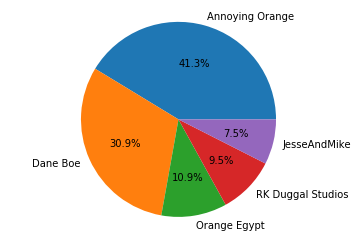

In [5]:
df2 = df1.groupby('channelTitle').sum().sort_values(ascending=False,by='viewCount').head()
plt.pie(df2['viewCount'],labels=df2.index.tolist(),autopct='%1.1f%%')
plt.axis('equal')
plt.show()

#### Analyze 3. A quick view in the channel named "Annoying Orange"
    簡單看一下Annoying Orange中影片的喜歡跟不喜歡人數的量(依觀看次數排列)

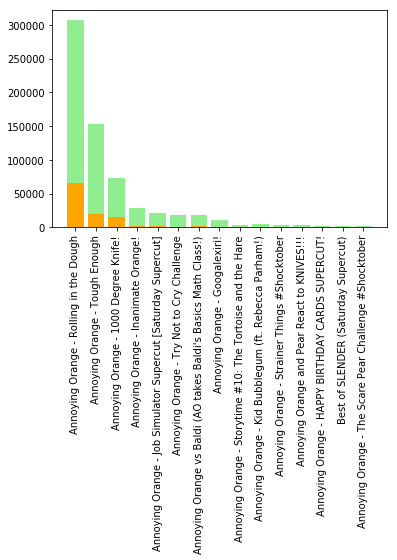

In [6]:
ImagineDragons = df1[df1['channelTitle']=='Annoying Orange']
ImagineDragons.sort_values(ascending=False,by='viewCount')

ImagineDragons = ImagineDragons.sort_values(ascending=False,by='viewCount')
plt.bar(range(ImagineDragons.shape[0]),ImagineDragons['likeCount'],color = 'lightgreen')
plt.bar(range(ImagineDragons.shape[0]),ImagineDragons['dislikeCount'],color='orange')
plt.xticks(range(ImagineDragons.shape[0]),ImagineDragons['Title'],rotation=90)
plt.show()

#### Analyze 4. caculate some relation between those arguements
    計算各種人數之間的比例關係 
       1. 每一萬觀看人次中留言的人數
       2. 每一萬觀看人次中點評的人數
       3. 每一百點評人次中留言的人數
       4. 洗餐跟不喜歡人次比
       
##### 討論 :
        Annoying Orange 跟 Dane Boe 的channel有著較高的留言比例。
        Orange Egypt 雖然留言比例不突出但是倒是都很裡點評。從第三項的比例中可得到驗證。
        而喜歡不喜歡比例最高的是 Dane Boe的頻道。

In [10]:
df3 = pd.DataFrame({"comment":[]})
df3.loc[:,'comment'] = df2['commentCount']/df2['viewCount']*10000
df3.loc[:,'like&dislike'] = (df2['likeCount']+df2['dislikeCount'])/df2['viewCount']*10000
df3.loc[:,'like vs comment'] =df2['commentCount']/(df2['likeCount']+df2['dislikeCount'])*100
df3.loc[:,'like vs dislike'] = df2['likeCount']/df2['dislikeCount']
print(df3)

                    comment  like&dislike  like vs comment  like vs dislike
channelTitle                                                               
Annoying Orange    3.034808     26.980729        11.248056         5.858820
Dane Boe           2.999829     22.346153        13.424364         6.604757
Orange Egypt       1.951799     56.057701         3.481768         4.476673
RK Duggal Studios  2.610312     43.770666         5.963610         5.298472
JesseAndMike       1.010883     21.547034         4.691519         2.375378


#### Analyze 5. Sum up the unique tags related to searching
    計算這些影片中，各種tags出現的次數。果然都蠻符合這顆橘子的性格跟特色。
    從前面到這都一直出現的daneboe到底是什麼呢?經由我手動google的結果，他便是這顆橘子的原創拉!
    

In [9]:
tag_list =[]
tag_list += df1['tags'].tolist()
tag_list = [val for sublist in tag_list for val in sublist]
#print(tag_list)

unique_elements, counts_elements = np.unique(tag_list, return_counts=True)
df4 = pd.DataFrame({"tags":unique_elements.tolist(),"number":counts_elements.tolist()})
df4 = df4.sort_values(ascending=False,by='number').head(n=10)
print(df4)

                    tags  number
97       annoying orange      18
271                funny      18
191              daneboe      18
600              talking      16
450               orange      16
263                fruit      16
95             animation      15
590                spoof      14
488               parody      14
79   The Annoying Orange      13


### Step4 : 來顆orange結束這一回合🍊🍊
    https://i.ytimg.com/vi/ZN5PoW7_kdA/hqdefault.jpg

https://i.ytimg.com/vi/ZN5PoW7_kdA/hqdefault.jpg


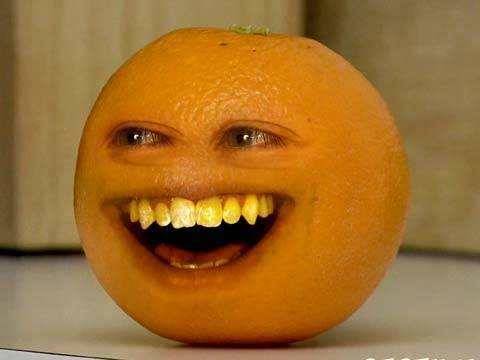

In [7]:
print(df1['url'][0])

from IPython.display import Image
Image(df1['url'][0])

### 其他 - 從網站上截取most popular的資料
    https://developers.google.com/youtube/v3/docs/videos/list#chart

In [8]:
dic = {
  "kind": "youtube#videoListResponse",
  "etag": "\"XI7nbFXulYBIpL0ayR_gDh3eu1k/iTZIEYwmCgLT378f1TnhvRfGfYo\"",
  "nextPageToken": "CAUQAA",
  "pageInfo": {
    "totalResults": 200,
    "resultsPerPage": 5
  },
  "items": [
    {
      "kind": "youtube#video",
      "etag": "\"XI7nbFXulYBIpL0ayR_gDh3eu1k/EjgoqT1ni8TK7UJUKdVCkwgFtA0\"",
      "id": "jOTiglSY9_0",
      "snippet": {
        "publishedAt": "2018-10-06T16:58:55.000Z",
        "channelId": "UCxnbaqzW_YO3sXD7GvH5vXw",
        "title": "2018第53屆電視金鐘獎頒獎典禮現場LIVE直播",
        "description": "【得獎名單】\n生活風格節目獎：我是留台幫\n生活風格節目主持人獎：廖科溢／秘境˙不思溢 III\n自然科學紀實節目獎：驚奇！博物館\n自然科學紀實節目主持人獎：陳家頤／驚奇！博物館\n迷你劇集（電視電影）新進演員獎：盧以恩／公視人生劇展-青苔\n迷你劇集（電視電影）男配角獎：喜翔／華視金選劇場-阮氏碧花與她的兩個男人\n迷你劇集（電視電影）女配角獎：廖怡裬／外鄉女-第三力量\n攝影獎：袁緒虎、傅士英／海•人•魚\n剪輯獎：林泰瑋／十點全紀錄\n音效獎：周震、福多瑪／公視學生劇展-棘\n燈光獎：陳冠廷／客家劇場–台北歌手\n美術設計獎：林仲賢、麥可姐【王郁文】、儲旭【儲榢逸】、凃維廷／麻醉風暴 2\n動畫節目獎：講麼个故事\n兒童少年節目獎：下課花路米-同理心大考驗系列\n兒童少年節目主持人獎：阿芹妹【鍾依芹】、阿迪牯【吳政迪】／麼个麼个\n終身成就獎：劉立立 女士\n特別貢獻獎：高振鵬 先生\n人文紀實節目主持人獎：舒夢蘭／聚焦全世界\n人文紀實節目獎：極樂世界\n節目創新獎：客家劇場–台北歌手\n非戲劇類節目導演獎：林泰瑋／十點全紀錄\n非戲劇類節目導播獎：劉應鐘／希望之星\n迷你劇集（電視電影）編劇獎：曾英庭、周語莊／高山上的茶園\n迷你劇集（電視電影）男主角獎：藍葦華／公視人生劇展-青苔\n迷你劇集（電視電影）女主角獎：陸弈靜／阿水和國祥\n迷你劇集（電視電影）導演獎：鄭有傑／他們在畢業的前一天爆炸 2\n迷你劇集獎：他們在畢業的前一天爆炸 2\n電視電影獎：公視人生劇展-青苔\n戲劇節目新進演員獎：盧廣仲／植劇場-花甲男孩轉大人\n戲劇節目男配角獎：劉冠廷／植劇場-花甲男孩轉大人\n戲劇節目女配角獎：楊小黎／客家劇場–台北歌手\n綜藝節目主持人獎：胡瓜【胡自雄】、阿翔【陳秉立】、謝忻【謝若葦】／綜藝大集合\n綜藝節目獎：閃亮的年代 Yesterday Once More\n益智及實境節目獎：天才衝衝衝\n益智及實境節目主持人獎：吳宗憲、KID【林柏昇】／綜藝玩很大\n戲劇節目編劇獎：樓一安、莫子儀／客家劇場–台北歌手\n戲劇節目女主角獎：黃姵嘉／客家劇場–台北歌手\n戲劇節目男主角獎：盧廣仲／植劇場-花甲男孩轉大人\n戲劇節目導演獎：何潤東、姜瑞智／翻牆的記憶\n戲劇節目獎：植劇場 花甲男孩轉大人\n\n金鐘53官方網站:http://gba.tavis.tw/53rd/index.html\n立刻訂閱金鐘53頻道:http://goo.gl/wF1rVl\n53金鐘APP這邊下載～👉🏻https://goo.gl/zahw6V\n官方粉絲團:https://www.facebook.com/bamid.goldenbell/\n\n第53屆廣播電視金鐘獎即將在台北國父紀念館盛大舉行：\n♟廣播金鐘獎 : 107年9月29日 19:00頒獎典禮\n♟電視金鐘獎 : 107年10月6日 17:00星光大道、19:00頒獎典禮",
        "thumbnails": {
          "default": {
            "url": "https://i.ytimg.com/vi/jOTiglSY9_0/default.jpg",
            "width": 120,
            "height": 90
          },
          "medium": {
            "url": "https://i.ytimg.com/vi/jOTiglSY9_0/mqdefault.jpg",
            "width": 320,
            "height": 180
          },
          "high": {
            "url": "https://i.ytimg.com/vi/jOTiglSY9_0/hqdefault.jpg",
            "width": 480,
            "height": 360
          }
        },
        "channelTitle": "2018第53屆 廣播電視金鐘獎 2018 53rd Golden Bell Awards",
        "tags": [
          "金鐘獎",
          "三立都會台",
          "三立電視",
          "文化部",
          "黃子佼",
          "宥勝",
          "吳宗憲",
          "綜藝玩很大",
          "綜藝大熱門",
          "陳漢典",
          "吳慷仁"
        ],
        "categoryId": "24",
        "liveBroadcastContent": "none",
        "localized": {
          "title": "2018第53屆電視金鐘獎頒獎典禮現場LIVE直播",
          "description": "【得獎名單】\n生活風格節目獎：我是留台幫\n生活風格節目主持人獎：廖科溢／秘境˙不思溢 III\n自然科學紀實節目獎：驚奇！博物館\n自然科學紀實節目主持人獎：陳家頤／驚奇！博物館\n迷你劇集（電視電影）新進演員獎：盧以恩／公視人生劇展-青苔\n迷你劇集（電視電影）男配角獎：喜翔／華視金選劇場-阮氏碧花與她的兩個男人\n迷你劇集（電視電影）女配角獎：廖怡裬／外鄉女-第三力量\n攝影獎：袁緒虎、傅士英／海•人•魚\n剪輯獎：林泰瑋／十點全紀錄\n音效獎：周震、福多瑪／公視學生劇展-棘\n燈光獎：陳冠廷／客家劇場–台北歌手\n美術設計獎：林仲賢、麥可姐【王郁文】、儲旭【儲榢逸】、凃維廷／麻醉風暴 2\n動畫節目獎：講麼个故事\n兒童少年節目獎：下課花路米-同理心大考驗系列\n兒童少年節目主持人獎：阿芹妹【鍾依芹】、阿迪牯【吳政迪】／麼个麼个\n終身成就獎：劉立立 女士\n特別貢獻獎：高振鵬 先生\n人文紀實節目主持人獎：舒夢蘭／聚焦全世界\n人文紀實節目獎：極樂世界\n節目創新獎：客家劇場–台北歌手\n非戲劇類節目導演獎：林泰瑋／十點全紀錄\n非戲劇類節目導播獎：劉應鐘／希望之星\n迷你劇集（電視電影）編劇獎：曾英庭、周語莊／高山上的茶園\n迷你劇集（電視電影）男主角獎：藍葦華／公視人生劇展-青苔\n迷你劇集（電視電影）女主角獎：陸弈靜／阿水和國祥\n迷你劇集（電視電影）導演獎：鄭有傑／他們在畢業的前一天爆炸 2\n迷你劇集獎：他們在畢業的前一天爆炸 2\n電視電影獎：公視人生劇展-青苔\n戲劇節目新進演員獎：盧廣仲／植劇場-花甲男孩轉大人\n戲劇節目男配角獎：劉冠廷／植劇場-花甲男孩轉大人\n戲劇節目女配角獎：楊小黎／客家劇場–台北歌手\n綜藝節目主持人獎：胡瓜【胡自雄】、阿翔【陳秉立】、謝忻【謝若葦】／綜藝大集合\n綜藝節目獎：閃亮的年代 Yesterday Once More\n益智及實境節目獎：天才衝衝衝\n益智及實境節目主持人獎：吳宗憲、KID【林柏昇】／綜藝玩很大\n戲劇節目編劇獎：樓一安、莫子儀／客家劇場–台北歌手\n戲劇節目女主角獎：黃姵嘉／客家劇場–台北歌手\n戲劇節目男主角獎：盧廣仲／植劇場-花甲男孩轉大人\n戲劇節目導演獎：何潤東、姜瑞智／翻牆的記憶\n戲劇節目獎：植劇場 花甲男孩轉大人\n\n金鐘53官方網站:http://gba.tavis.tw/53rd/index.html\n立刻訂閱金鐘53頻道:http://goo.gl/wF1rVl\n53金鐘APP這邊下載～👉🏻https://goo.gl/zahw6V\n官方粉絲團:https://www.facebook.com/bamid.goldenbell/\n\n第53屆廣播電視金鐘獎即將在台北國父紀念館盛大舉行：\n♟廣播金鐘獎 : 107年9月29日 19:00頒獎典禮\n♟電視金鐘獎 : 107年10月6日 17:00星光大道、19:00頒獎典禮"
        },
        "defaultAudioLanguage": "zh-TW"
      },
      "contentDetails": {
        "duration": "PT4H46M53S",
        "dimension": "2d",
        "definition": "hd",
        "caption": "false",
        "licensedContent": "true",
        "regionRestriction": {
          "blocked": [
            "CA",
            "SG",
            "US"
          ]
        },
        "projection": "rectangular"
      },
      "statistics": {
        "viewCount": "676714",
        "likeCount": "1940",
        "dislikeCount": "316",
        "favoriteCount": "0",
        "commentCount": "248"
      }
    },
    {
      "kind": "youtube#video",
      "etag": "\"XI7nbFXulYBIpL0ayR_gDh3eu1k/KBvYq-Jd7D4Zdd5liU3O8h3xelQ\"",
      "id": "akTije29bPE",
      "snippet": {
        "publishedAt": "2018-10-06T10:00:00.000Z",
        "channelId": "UCAsviiS5DE0pcuvxPRrrAzQ",
        "title": "【巨大】史上最大泡麵！超過2000卡路里 ft.黃氏兄弟",
        "description": "搞神馬把泡麵巨大化！2142卡路里大胃王挑戰！【黃氏兄弟】\nhttps://youtu.be/GBVuQnerz54\n\n❤ 每周三、六、日都有新影片 !! 從今天起開始訂閱吧 !! ❤\n在Facebook上追蹤我們 ➔ https://www.facebook.com/ksmytstudio\n\n🎬更多影片🎬\n\n🍔食物系列🍟:https://goo.gl/fA7y1Z\n💥日常系列💥:https://goo.gl/qfbhyP\n\n以下是我們的主頻道！歡迎來認識我們！\n（香港人）馬田（廚藝）：https://www.youtube.com/user/dimcookguide\n（台灣人）阿神（遊戲）：https://www.youtube.com/user/charlie615119",
        "thumbnails": {
          "default": {
            "url": "https://i.ytimg.com/vi/akTije29bPE/default.jpg",
            "width": 120,
            "height": 90
          },
          "medium": {
            "url": "https://i.ytimg.com/vi/akTije29bPE/mqdefault.jpg",
            "width": 320,
            "height": 180
          },
          "high": {
            "url": "https://i.ytimg.com/vi/akTije29bPE/hqdefault.jpg",
            "width": 480,
            "height": 360
          },
          "standard": {
            "url": "https://i.ytimg.com/vi/akTije29bPE/sddefault.jpg",
            "width": 640,
            "height": 480
          },
          "maxres": {
            "url": "https://i.ytimg.com/vi/akTije29bPE/maxresdefault.jpg",
            "width": 1280,
            "height": 720
          }
        },
        "channelTitle": "搞神馬",
        "categoryId": "22",
        "liveBroadcastContent": "none",
        "defaultLanguage": "zh-TW",
        "localized": {
          "title": "【巨大】史上最大泡麵！超過2000卡路里 ft.黃氏兄弟",
          "description": "搞神馬把泡麵巨大化！2142卡路里大胃王挑戰！【黃氏兄弟】\nhttps://youtu.be/GBVuQnerz54\n\n❤ 每周三、六、日都有新影片 !! 從今天起開始訂閱吧 !! ❤\n在Facebook上追蹤我們 ➔ https://www.facebook.com/ksmytstudio\n\n🎬更多影片🎬\n\n🍔食物系列🍟:https://goo.gl/fA7y1Z\n💥日常系列💥:https://goo.gl/qfbhyP\n\n以下是我們的主頻道！歡迎來認識我們！\n（香港人）馬田（廚藝）：https://www.youtube.com/user/dimcookguide\n（台灣人）阿神（遊戲）：https://www.youtube.com/user/charlie615119"
        }
      },
      "contentDetails": {
        "duration": "PT11M59S",
        "dimension": "2d",
        "definition": "hd",
        "caption": "false",
        "licensedContent": "true",
        "projection": "rectangular"
      },
      "statistics": {
        "viewCount": "514937",
        "likeCount": "12525",
        "dislikeCount": "595",
        "favoriteCount": "0",
        "commentCount": "1260"
      }
    },
    {
      "kind": "youtube#video",
      "etag": "\"XI7nbFXulYBIpL0ayR_gDh3eu1k/fOiPSYuTI8s59UjUw44A41zZag0\"",
      "id": "jQmRBv0hjS0",
      "snippet": {
        "publishedAt": "2018-10-07T04:00:00.000Z",
        "channelId": "UCVF3bTd3dxM4IfOMFCbNADA",
        "title": "【1007】卡提諾狂新聞 #136",
        "description": "【1007】卡提諾狂新聞 #136\n\n※ 帶來和平的柯？！\n※ 抖到你媽都認不出來\n※ 恐怖鵝~恐怖到了極點鵝~\n※ 痛心啊！\n※ 路上好車好恐怖阿～\n\n卡提諾狂新聞粉絲團設為搶先看！\n搶先收到第一手狂訊～\nhttps://www.facebook.com/crazyck101/ \n\n#追蹤狂新聞IG #追蹤的都30cm\nhttps://www.instagram.com/crazy.ck101/\n\n#卡提諾狂新聞 #948794狂\n\n本集新聞來源：華視、光頭哥哥、新唐人、三立、中視、民視、即新聞、自由時報、中時、YAHOO、自由時報、東森、聽見山域求救聲音",
        "thumbnails": {
          "default": {
            "url": "https://i.ytimg.com/vi/jQmRBv0hjS0/default.jpg",
            "width": 120,
            "height": 90
          },
          "medium": {
            "url": "https://i.ytimg.com/vi/jQmRBv0hjS0/mqdefault.jpg",
            "width": 320,
            "height": 180
          },
          "high": {
            "url": "https://i.ytimg.com/vi/jQmRBv0hjS0/hqdefault.jpg",
            "width": 480,
            "height": 360
          },
          "standard": {
            "url": "https://i.ytimg.com/vi/jQmRBv0hjS0/sddefault.jpg",
            "width": 640,
            "height": 480
          },
          "maxres": {
            "url": "https://i.ytimg.com/vi/jQmRBv0hjS0/maxresdefault.jpg",
            "width": 1280,
            "height": 720
          }
        },
        "channelTitle": "卡提諾狂新聞",
        "categoryId": "25",
        "liveBroadcastContent": "none",
        "localized": {
          "title": "【1007】卡提諾狂新聞 #136",
          "description": "【1007】卡提諾狂新聞 #136\n\n※ 帶來和平的柯？！\n※ 抖到你媽都認不出來\n※ 恐怖鵝~恐怖到了極點鵝~\n※ 痛心啊！\n※ 路上好車好恐怖阿～\n\n卡提諾狂新聞粉絲團設為搶先看！\n搶先收到第一手狂訊～\nhttps://www.facebook.com/crazyck101/ \n\n#追蹤狂新聞IG #追蹤的都30cm\nhttps://www.instagram.com/crazy.ck101/\n\n#卡提諾狂新聞 #948794狂\n\n本集新聞來源：華視、光頭哥哥、新唐人、三立、中視、民視、即新聞、自由時報、中時、YAHOO、自由時報、東森、聽見山域求救聲音"
        },
        "defaultAudioLanguage": "zh-TW"
      },
      "contentDetails": {
        "duration": "PT5M52S",
        "dimension": "2d",
        "definition": "hd",
        "caption": "false",
        "licensedContent": "false",
        "projection": "rectangular"
      },
      "statistics": {
        "viewCount": "549899",
        "likeCount": "7564",
        "dislikeCount": "519",
        "favoriteCount": "0",
        "commentCount": "1576"
      }
    },
    {
      "kind": "youtube#video",
      "etag": "\"XI7nbFXulYBIpL0ayR_gDh3eu1k/lyiBnlJfZgWfu1nof9llZcdZEoY\"",
      "id": "qVg1NlzE5wk",
      "snippet": {
        "publishedAt": "2018-10-05T10:00:38.000Z",
        "channelId": "UCw2W7GIqJNB-UMUxncnMuiw",
        "title": "【黃阿瑪的後宮生活】用寶特瓶封印貓！實測",
        "description": "招弟：「這樣會讓我動不了？」\n× 頻道更新時間為週五晚間六點，其餘時段不定時發舊片！×\n訂閱我們吧：https://goo.gl/5L8xkV\n\n【你看過惡劣的寵物繁殖場嗎？】志銘與狸貓\n▶ https://youtu.be/I9JLnF6grBs\n\n---\n\n近期週邊：\n好好帶飲料提袋：\n【蝦皮購物】：https://goo.gl/Lwwyh9\n【PChome】：https://goo.gl/jkNcsd\n【PChome中港澳瑪民專區】：https://goo.gl/BFeBXW\n× 目前賣光光了，等下一波預購開放時會再公佈喔～ ×\n\n---\n\n更多影片：\n慢動作看後宮：https://goo.gl/o2vVAH\n後宮慶生系列：https://goo.gl/pwYm6Y\n眾貓的一天：https://goo.gl/FGEFwt\n療癒喵喵系列：https://goo.gl/haqaFq\n後宮喵喵去醫院：https://goo.gl/n4tH6i\n貓咪受難系列：https://goo.gl/BvkYyx\n貓貓知識小學堂：https://goo.gl/ynQPx3\n阿瑪賴著不走：https://goo.gl/gjb7AL\n後宮年節系列：https://goo.gl/wZv4bx\n後宮厲害的作品：https://goo.gl/xLZtKu\n後宮阿瑪傳：https://goo.gl/GqqQ4c\n阿瑪的直播：https://goo.gl/uEu33k\n\n---\n\n【四本著作】\n《貓永遠是對的》▶  https://goo.gl/kEFK1i\n《被貓咪包圍的日子》▶https://goo.gl/2sw2aG\n《後宮交換日記》▶ http://goo.gl/02ZJ64\n《阿瑪建國史》▶ http://goo.gl/QJtRXk\n\n---\n\n歡迎替朕翻譯\n▶ http://www.youtube.com/timedtext_video?v=qVg1NlzE5wk&ref=share\n\n---\n\n【主題】阿瑪Line原創主題\n▶https://goo.gl/6rFMyU\n\n---\n\n【朕的Line系列貼圖】\n全螢幕有聲貼圖-黃阿瑪滿出來了！\nhttp://line.me/S/sticker/8660\n\n第二代後宮真貓 有聲貼圖\nhttp://line.me/S/sticker/7945\n\n第一代後宮真貓 有聲貼圖\nhttp://line.me/S/sticker/6569\n\n寂寞無聊的胡言亂語 貼圖\nhttp://line.me/S/sticker/1351666\n\n第一代 後宮插畫 動態貼圖\nhttp://line.me/S/sticker/6269 \n\n---\n\n【黃阿瑪的後宮生活】About fumeancats \n我們都住在臺灣臺北，後宮以黃阿瑪(貓)為首，帶領其他六位後宮成員(招弟、三腳、Socles、嚕嚕、柚子、浣腸) 與兩位奴才-志銘與狸貓(人)，以照片和影片分享萬睡皇朝的私密趣事，目前擁有四本著作。7cats , We live in Taiwan,Taipei！\n\n【黃阿瑪的後宮生活】Website \n\nFacebook：www.facebook.com/fumeancats\nYoutube：https://goo.gl/N7m313\ninstagram：http://instagram.com/fumeancat/\n微博：http://weibo.com/fumeancats\n美拍： www.meipai.com/user/1023155987\nTwitter：https://twitter.com/Fumeancats\n瑪瑪商行（蝦皮賣場）：https://shopee.tw/fumeancats\n瑪瑪商行（PChome）：https://goo.gl/JaFsmT\n黃阿瑪的後宮生活誌：http://fumeancats.talk.tw/\nLine ID：@sbq7719e（直接在搜尋好友輸入就可以找到朕囉～記得要加上@喔～）\n\n\n【狸貓Youtube】https://goo.gl/urHuAX\n【志銘Youtube】https://goo.gl/cHWBmY\n\n〔版權所有，盜版砍頭〕\n〔領養不棄養〕",
        "thumbnails": {
          "default": {
            "url": "https://i.ytimg.com/vi/qVg1NlzE5wk/default.jpg",
            "width": 120,
            "height": 90
          },
          "medium": {
            "url": "https://i.ytimg.com/vi/qVg1NlzE5wk/mqdefault.jpg",
            "width": 320,
            "height": 180
          },
          "high": {
            "url": "https://i.ytimg.com/vi/qVg1NlzE5wk/hqdefault.jpg",
            "width": 480,
            "height": 360
          },
          "standard": {
            "url": "https://i.ytimg.com/vi/qVg1NlzE5wk/sddefault.jpg",
            "width": 640,
            "height": 480
          }
        },
        "channelTitle": "黃阿瑪的後宮生活",
        "tags": [
          "黃阿瑪",
          "阿瑪",
          "寶特瓶",
          "傳說",
          "迷思",
          "實測",
          "測試",
          "測驗",
          "貓咪",
          "貓",
          "寵物",
          "療癒",
          "萌",
          "可愛",
          "實驗",
          "塑膠瓶"
        ],
        "categoryId": "15",
        "liveBroadcastContent": "none",
        "defaultLanguage": "zh-TW",
        "localized": {
          "title": "【黃阿瑪的後宮生活】用寶特瓶封印貓！實測",
          "description": "招弟：「這樣會讓我動不了？」\n× 頻道更新時間為週五晚間六點，其餘時段不定時發舊片！×\n訂閱我們吧：https://goo.gl/5L8xkV\n\n【你看過惡劣的寵物繁殖場嗎？】志銘與狸貓\n▶ https://youtu.be/I9JLnF6grBs\n\n---\n\n近期週邊：\n好好帶飲料提袋：\n【蝦皮購物】：https://goo.gl/Lwwyh9\n【PChome】：https://goo.gl/jkNcsd\n【PChome中港澳瑪民專區】：https://goo.gl/BFeBXW\n× 目前賣光光了，等下一波預購開放時會再公佈喔～ ×\n\n---\n\n更多影片：\n慢動作看後宮：https://goo.gl/o2vVAH\n後宮慶生系列：https://goo.gl/pwYm6Y\n眾貓的一天：https://goo.gl/FGEFwt\n療癒喵喵系列：https://goo.gl/haqaFq\n後宮喵喵去醫院：https://goo.gl/n4tH6i\n貓咪受難系列：https://goo.gl/BvkYyx\n貓貓知識小學堂：https://goo.gl/ynQPx3\n阿瑪賴著不走：https://goo.gl/gjb7AL\n後宮年節系列：https://goo.gl/wZv4bx\n後宮厲害的作品：https://goo.gl/xLZtKu\n後宮阿瑪傳：https://goo.gl/GqqQ4c\n阿瑪的直播：https://goo.gl/uEu33k\n\n---\n\n【四本著作】\n《貓永遠是對的》▶  https://goo.gl/kEFK1i\n《被貓咪包圍的日子》▶https://goo.gl/2sw2aG\n《後宮交換日記》▶ http://goo.gl/02ZJ64\n《阿瑪建國史》▶ http://goo.gl/QJtRXk\n\n---\n\n歡迎替朕翻譯\n▶ http://www.youtube.com/timedtext_video?v=qVg1NlzE5wk&ref=share\n\n---\n\n【主題】阿瑪Line原創主題\n▶https://goo.gl/6rFMyU\n\n---\n\n【朕的Line系列貼圖】\n全螢幕有聲貼圖-黃阿瑪滿出來了！\nhttp://line.me/S/sticker/8660\n\n第二代後宮真貓 有聲貼圖\nhttp://line.me/S/sticker/7945\n\n第一代後宮真貓 有聲貼圖\nhttp://line.me/S/sticker/6569\n\n寂寞無聊的胡言亂語 貼圖\nhttp://line.me/S/sticker/1351666\n\n第一代 後宮插畫 動態貼圖\nhttp://line.me/S/sticker/6269 \n\n---\n\n【黃阿瑪的後宮生活】About fumeancats \n我們都住在臺灣臺北，後宮以黃阿瑪(貓)為首，帶領其他六位後宮成員(招弟、三腳、Socles、嚕嚕、柚子、浣腸) 與兩位奴才-志銘與狸貓(人)，以照片和影片分享萬睡皇朝的私密趣事，目前擁有四本著作。7cats , We live in Taiwan,Taipei！\n\n【黃阿瑪的後宮生活】Website \n\nFacebook：www.facebook.com/fumeancats\nYoutube：https://goo.gl/N7m313\ninstagram：http://instagram.com/fumeancat/\n微博：http://weibo.com/fumeancats\n美拍： www.meipai.com/user/1023155987\nTwitter：https://twitter.com/Fumeancats\n瑪瑪商行（蝦皮賣場）：https://shopee.tw/fumeancats\n瑪瑪商行（PChome）：https://goo.gl/JaFsmT\n黃阿瑪的後宮生活誌：http://fumeancats.talk.tw/\nLine ID：@sbq7719e（直接在搜尋好友輸入就可以找到朕囉～記得要加上@喔～）\n\n\n【狸貓Youtube】https://goo.gl/urHuAX\n【志銘Youtube】https://goo.gl/cHWBmY\n\n〔版權所有，盜版砍頭〕\n〔領養不棄養〕"
        },
        "defaultAudioLanguage": "en-US"
      },
      "contentDetails": {
        "duration": "PT7M13S",
        "dimension": "2d",
        "definition": "hd",
        "caption": "false",
        "licensedContent": "true",
        "projection": "rectangular"
      },
      "statistics": {
        "viewCount": "596936",
        "likeCount": "22370",
        "dislikeCount": "280",
        "favoriteCount": "0",
        "commentCount": "1569"
      }
    },
    {
      "kind": "youtube#video",
      "etag": "\"XI7nbFXulYBIpL0ayR_gDh3eu1k/9t5vFUpjxURxq_OptC71O6bphZY\"",
      "id": "SE5mqsCcUH8",
      "snippet": {
        "publishedAt": "2018-10-06T12:40:07.000Z",
        "channelId": "UCg8EwsqYmiw7G267xxPyXsg",
        "title": "挑戰史上最快嘴！那吾克熱問鼎《中國新說唱》冠軍歌曲《水滴石穿》｜NOWnews今日新聞",
        "description": "更多相關新聞請上：http://www.nownews.com/\n\n─【NOWnews今日新聞】─",
        "thumbnails": {
          "default": {
            "url": "https://i.ytimg.com/vi/SE5mqsCcUH8/default.jpg",
            "width": 120,
            "height": 90
          },
          "medium": {
            "url": "https://i.ytimg.com/vi/SE5mqsCcUH8/mqdefault.jpg",
            "width": 320,
            "height": 180
          },
          "high": {
            "url": "https://i.ytimg.com/vi/SE5mqsCcUH8/hqdefault.jpg",
            "width": 480,
            "height": 360
          },
          "standard": {
            "url": "https://i.ytimg.com/vi/SE5mqsCcUH8/sddefault.jpg",
            "width": 640,
            "height": 480
          }
        },
        "channelTitle": "NOWnews",
        "tags": [
          "中國新說唱",
          "新說唱",
          "吳亦凡",
          "滴水穿石",
          "那吾克熱",
          "鄧紫棋",
          "潘瑋柏",
          "艾熱"
        ],
        "categoryId": "24",
        "liveBroadcastContent": "none",
        "localized": {
          "title": "挑戰史上最快嘴！那吾克熱問鼎《中國新說唱》冠軍歌曲《水滴石穿》｜NOWnews今日新聞",
          "description": "更多相關新聞請上：http://www.nownews.com/\n\n─【NOWnews今日新聞】─"
        }
      },
      "contentDetails": {
        "duration": "PT3M15S",
        "dimension": "2d",
        "definition": "hd",
        "caption": "false",
        "licensedContent": "true",
        "projection": "rectangular"
      },
      "statistics": {
        "viewCount": "639707",
        "likeCount": "6685",
        "dislikeCount": "756",
        "favoriteCount": "0",
        "commentCount": "2164"
      }
    }
  ]
}

In [11]:
print(dic['items'][0].keys())

dict_keys(['kind', 'etag', 'id', 'snippet', 'contentDetails', 'statistics'])
